In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# Custom preprocessing pipeline
from senti_pipeline import pipeline_for_sentiment

# NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lowie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lowie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lowie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load dataset

df = pd.read_csv("data_atlanta/atlanta_restaurant_slice_2023.csv")

df = df[['text', 'stars']].dropna()
df = df[df['text'].astype(str).str.strip() != ""]

## Data Preparation for Sentiment Analysis

Text preprocessing was designed to preserve sentiment-bearing structures while removing irrelevant noise.

The preprocessing pipeline includes:
- Removal of URLs and emojis
- Diacritic normalization
- Lowercasing
- Tokenization and lemmatization
- Preservation of negations and sentiment punctuation (e.g., *not good*, *very bad!*, *excellent!*)

Unlike generic text-cleaning pipelines, this approach avoids removing stopwords or punctuation that may alter sentiment polarity. The goal is to retain linguistic cues that contribute to emotional meaning.

In [3]:
# Sentiment-aware preprocessing

def preprocess_review(text):
    return pipeline_for_sentiment(
        text,
        lowercase=True,
        lemmatize=True,
        convert_diacritics=True
    )

df['clean_text'] = df['text'].apply(preprocess_review)

## Sentiment Polarity Extraction

To assess the relationship between textual sentiment and star ratings, two lexicon-based sentiment analysis tools are employed:

- **VADER**, which is optimized for short, informal texts and captures sentiment intensity and negation.
- **TextBlob**, which provides a continuous polarity score based on the Pattern library.

Both methods return polarity scores in the range **[-1, 1]**, where negative values indicate negative sentiment and positive values indicate positive sentiment.

In [4]:
# Polarity computation

sia = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['text'].apply(lambda t: sia.polarity_scores(t)['compound'])
df['textblob_polarity'] = df['text'].apply(lambda t: TextBlob(t).sentiment.polarity)

## Relationship Between Polarity and Star Ratings

To evaluate how strongly sentiment polarity aligns with user-provided star ratings, several complementary analyses are conducted:

- **Pearson correlation coefficients** between polarity scores and star ratings
- **Visual exploration** of polarity distributions by star level
- **Regression-style evaluation**, where polarity scores are scaled to the 1–5 range to compute RMSE and MAPE

This combination of numerical and visual methods allows for a robust assessment of the strength and consistency of the relationship between textual sentiment and numerical ratings.

In [5]:
# Correlation analysis

pear_v = pearsonr(df['vader_polarity'], df['stars'])
pear_b = pearsonr(df['textblob_polarity'], df['stars'])

print("VADER Pearson correlation:", pear_v)
print("TextBlob Pearson correlation:", pear_b)

VADER Pearson correlation: PearsonRResult(statistic=np.float64(0.6749031295589656), pvalue=np.float64(0.0))
TextBlob Pearson correlation: PearsonRResult(statistic=np.float64(0.6320557741820058), pvalue=np.float64(0.0))


To quantify the relationship between textual sentiment and star ratings, Pearson correlation coefficients were computed.

- **VADER polarity vs. stars**: r = **0.675**, p < 0.001  
- **TextBlob polarity vs. stars**: r = **0.632**, p < 0.001  

Both correlations are statistically significant and indicate a **moderate-to-strong positive relationship**.
The stronger correlation observed for VADER confirms the visual evidence that it aligns more closely with user-provided ratings.

In [6]:
# Regression-style evaluation

def scale_to_stars(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    return (scaled * 4 + 1).flatten()

pred_v = scale_to_stars(df['vader_polarity'])
pred_b = scale_to_stars(df['textblob_polarity'])

print("VADER RMSE:", np.sqrt(mean_squared_error(df['stars'], pred_v)))
print("TextBlob RMSE:", np.sqrt(mean_squared_error(df['stars'], pred_b)))

print("VADER MAPE:", mean_absolute_percentage_error(df['stars'], pred_v))
print("TextBlob MAPE:", mean_absolute_percentage_error(df['stars'], pred_b))

VADER RMSE: 1.0699519336878796
TextBlob RMSE: 1.1835101127119587
VADER MAPE: 0.34769285911553544
TextBlob MAPE: 0.4107279748263037


To further assess alignment between polarity scores and numerical ratings, sentiment polarity values were scaled to the 1–5 star range and evaluated using regression-style metrics.

VADER achieved a lower RMSE (1.07) and lower MAPE (0.35) than TextBlob (RMSE = 1.18, MAPE = 0.41), indicating more accurate approximation of star ratings.

These results suggest that, although neither method perfectly predicts user ratings, VADER provides a more faithful numerical representation of sentiment expressed in text.

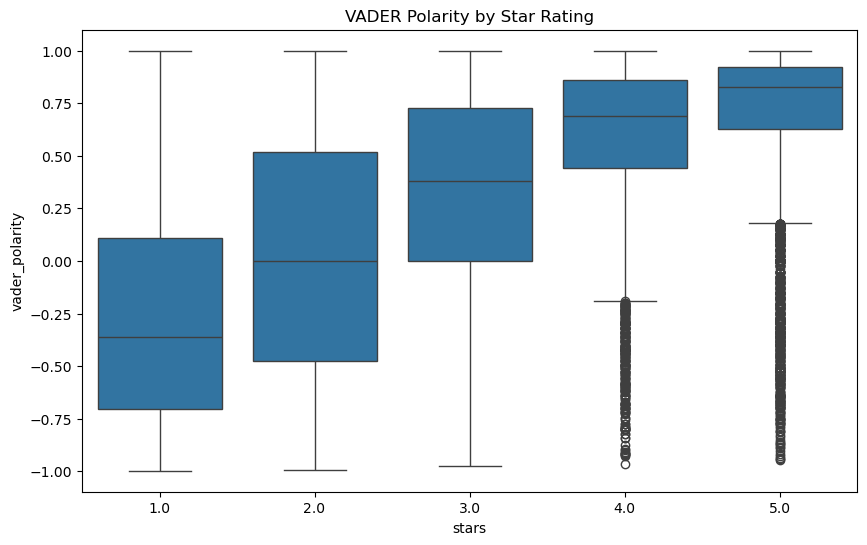

In [7]:
# Visualisations

plt.figure(figsize=(10,6))
sns.boxplot(x=df['stars'], y=df['vader_polarity'])
plt.title("VADER Polarity by Star Rating")
plt.show()

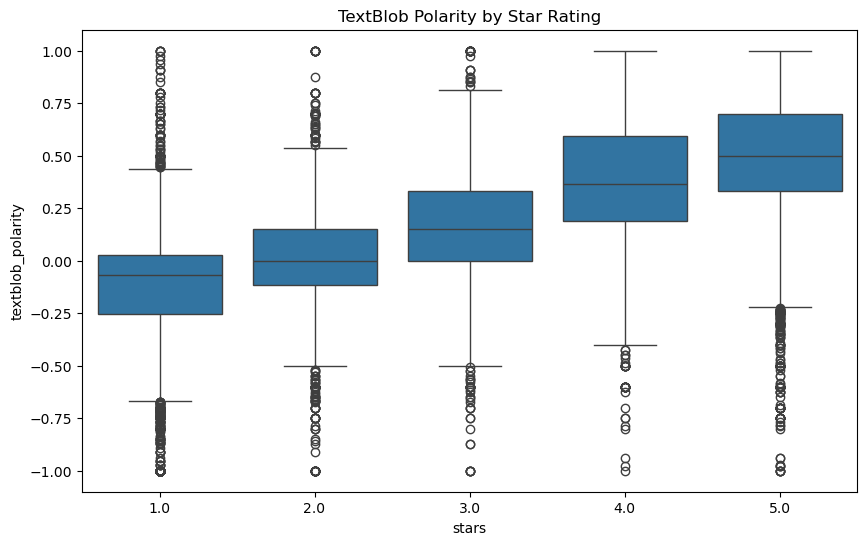

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['stars'], y=df['textblob_polarity'])
plt.title("TextBlob Polarity by Star Rating")
plt.show()

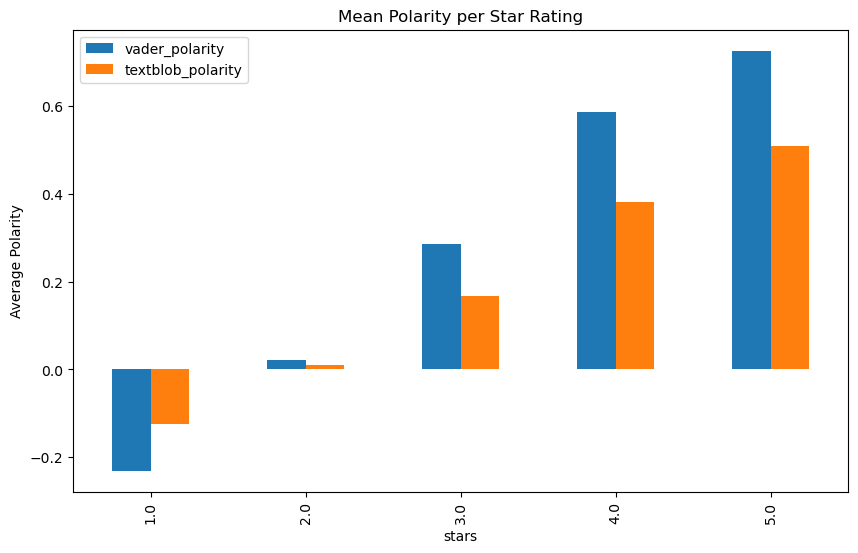

In [9]:
mean_vals = df.groupby('stars')[['vader_polarity', 'textblob_polarity']].mean()
mean_vals.plot(kind='bar', figsize=(10,6))
plt.title("Mean Polarity per Star Rating")
plt.ylabel("Average Polarity")
plt.show()

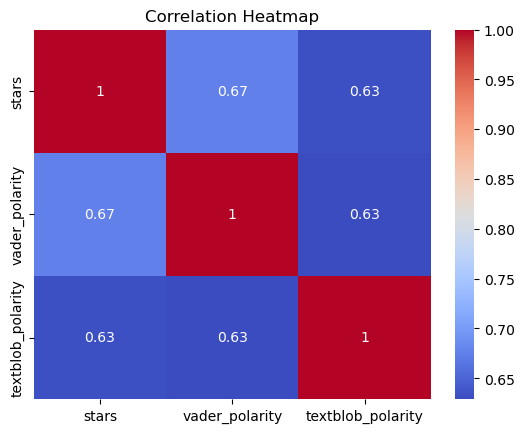

In [10]:
sns.heatmap(df[['stars', 'vader_polarity', 'textblob_polarity']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Interpretation of Polarity Results

Figure 1 shows the distribution of sentiment polarity scores across star ratings using the VADER sentiment analyser.
A clear monotonic trend is visible: reviews with lower star ratings tend to exhibit negative polarity, while higher star ratings are associated with increasingly positive sentiment.

Median VADER polarity increases steadily from approximately **−0.23 for 1 star reviews** to above **0.7 for 5 star reviews**, indicating a strong alignment between textual sentiment and numerical ratings.
Nevertheless, substantial overlap exists between adjacent star levels, particularly between 2★–3★ and 4★–5★ reviews, suggesting that star ratings do not fully capture the nuances expressed in free-text comments.

Figure 2 compares polarity distributions obtained using TextBlob.
While TextBlob also shows an increasing polarity trend with higher star ratings, the separation between classes is less pronounced than for VADER.

In particular, TextBlob polarity values are more compressed around zero, especially for lower star ratings, indicating reduced sensitivity to strong negative sentiment.
This suggests that VADER may be better suited to capturing sentiment intensity in short, informal restaurant reviews.

The average polarity scores per star rating further confirm this trend.
Mean VADER polarity increases from **−0.23 (1 star)** to **0.73 (5 star)**, while TextBlob polarity rises from approximately **−0.12 to 0.50** over the same range.

Across all star levels, VADER produces more extreme polarity values than TextBlob, indicating a stronger differentiation between sentiment levels.
This difference is particularly evident for negative reviews, where VADER assigns substantially lower polarity scores.

## Supervised Sentiment Classification

In addition to polarity analysis, a supervised learning approach is used to model sentiment explicitly.
Star ratings are converted into sentiment classes:

- **Negative**: 1–2 stars
- **Neutral**: 3 stars
- **Positive**: 4–5 stars

This transformation enables the training of a sentiment classifier and provides a basis for evaluating how well textual features alone can recover sentiment labels derived from ratings.


In [11]:
# Label creation from stars

def label_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

In [12]:
df['sentiment'] = df['stars'].apply(label_sentiment)

print(df['sentiment'].value_counts())

sentiment
positive    40099
negative     9933
neutral      3534
Name: count, dtype: int64


## Feature Extraction

Text is converted into numerical features using TF–IDF.

Both unigrams and bigrams are used to capture:
- Individual sentiment-bearing words (e.g., *great*, *terrible*)
- Short expressions (e.g., *not good*, *very slow*)

Rare terms are excluded to reduce noise and dimensionality.


In [13]:
# TF–IDF feature extraction

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

## Model Training and Evaluation

A multinomial Logistic Regression classifier is trained on TF–IDF features.
The dataset is split into training and test sets using stratified sampling to preserve class proportions.

Model performance is evaluated using:
- Accuracy
- Precision, recall, and F1-score per class
- Macro and weighted F1-scores
- Confusion matrix

These metrics provide insight into both overall performance and class-specific behaviour.


In [14]:
# Train / test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [15]:
# Logistic Regression model

model = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    n_jobs=-1
)

model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1)

In [16]:
# Evaluation

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Macro F1:", macro_f1)
print("Weighted F1:", weighted_f1)

Accuracy: 0.8982639537054321

Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      1987
     neutral       0.52      0.20      0.29       707
    positive       0.93      0.97      0.95      8020

    accuracy                           0.90     10714
   macro avg       0.75      0.67      0.69     10714
weighted avg       0.88      0.90      0.89     10714

Macro F1: 0.6888247837443128
Weighted F1: 0.8850440843279462


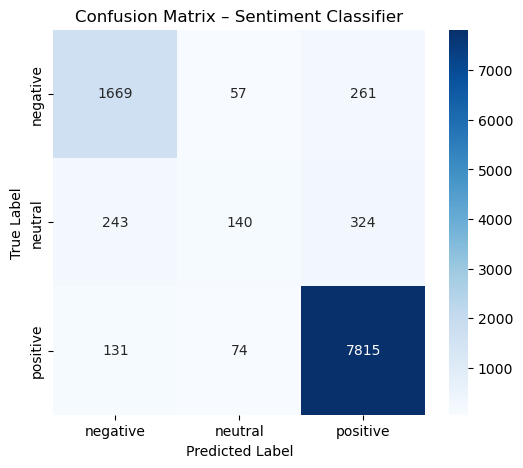

In [17]:
# Confusion Matrix

labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Confusion Matrix – Sentiment Classifier")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The classifier achieved an overall **accuracy of 89.8%**, with a **weighted F1-score of 0.89** and a **macro F1-score of 0.69**.
The discrepancy between macro and weighted F1-scores reflects class imbalance in the dataset, with positive reviews being the most frequent.

The confusion matrix reveals strong performance for both negative and positive classes.
Positive reviews are classified with particularly high recall (0.97), indicating that the model is highly effective at identifying clearly positive sentiment.

In contrast, the neutral class is substantially more challenging, with a recall of only 0.20.
Many neutral reviews are misclassified as either negative or positive, highlighting the inherent ambiguity of mid-range ratings and the overlap of sentiment expressions around neutrality.

## Model Interpretability

To improve interpretability, the most influential TF–IDF features for each sentiment class are examined.
This analysis highlights words and expressions that the model associates most strongly with negative, neutral, and positive sentiment, offering qualitative validation of the learned patterns.

In [18]:
# Feature importance

feature_names = np.array(vectorizer.get_feature_names_out())

for i, label in enumerate(model.classes_):
    top_idx = np.argsort(model.coef_[i])[-20:]
    print(f"\nTop features for {label.upper()}")
    for word, weight in zip(feature_names[top_idx][::-1], model.coef_[i][top_idx][::-1]):
        print(f"{word}: {round(weight, 3)}")


Top features for NEGATIVE
worst: 4.99
terrible: 4.532
horrible: 4.508
rude: 3.871
not: 3.288
disgusting: 3.274
awful: 3.238
no: 3.234
poor: 2.774
closed: 2.56
burnt: 2.526
bland: 2.464
roach: 2.35
worse: 2.34
bad: 2.316
nasty: 2.256
not good: 2.251
sick: 2.236
told: 2.182
didn: 2.149

Top features for NEUTRAL
average: 3.411
okay: 3.059
ok: 2.579
but: 2.163
decent: 2.004
so so: 1.909
probably: 1.838
however: 1.806
mediocre: 1.708
unfortunately: 1.705
except: 1.695
for what: 1.674
alright: 1.614
not so: 1.574
not: 1.525
at best: 1.501
great but: 1.484
meh: 1.465
did: 1.377
is usually: 1.364

Top features for POSITIVE
great: 6.455
delicious: 5.331
amazing: 5.264
excellent: 5.152
best: 4.684
love: 3.911
awesome: 3.72
wonderful: 3.362
perfect: 3.057
fantastic: 2.981
good: 2.975
loved: 2.877
favorite: 2.559
yummy: 2.542
definitely: 2.397
incredible: 2.355
excelente: 2.34
quickly: 2.286
fresh: 2.257
friendly: 2.215


Negative sentiment is strongly associated with terms such as *“worst”*, *“terrible”*, *“horrible”*, *“rude”*, and negation-based expressions like *“not good”*.
Neutral sentiment is characterised by hedging and mixed expressions such as *“average”*, *“okay”*, *“but”*, *“however”*, and *“so so”*.
Positive sentiment is dominated by clearly affective terms, including *“great”*, *“delicious”*, *“amazing”*, *“excellent”*, and *“love”*.

These patterns align well with intuitive expectations and support the validity of the trained classifier.

## Conclusion

The results demonstrate a clear and statistically significant relationship between textual sentiment polarity and star ratings in restaurant reviews.
Lexicon-based methods reveal strong monotonic trends, with VADER showing consistently stronger alignment with numerical ratings than TextBlob.

Supervised classification further confirms that sentiment can be reliably inferred from review text alone, particularly for strongly positive and negative opinions.
However, neutral sentiment remains challenging to identify due to linguistic ambiguity and overlap with adjacent sentiment classes.

Overall, these findings confirm that free-text reviews provide valuable information beyond numerical ratings and that sentiment analysis constitutes an effective tool for understanding customer experience in the restaurant domain.